# CISA KVE EPSS Data Analyis 

In [1]:
import pandas as pd
import json
import requests
import os
import glob
import numpy as np

In [2]:
cisa_df = pd.read_csv("https://www.cisa.gov/sites/default/files/csv/known_exploited_vulnerabilities.csv")
cisa_df = cisa_df
cisa_df.columns = cisa_df.columns.str.strip("\u200b")
cisa_df = cisa_df.rename(columns={"cveID": "CVE", "shortDescription" : "Description", "vendorProject" : "Vendor", "product" : "Product"})

In [3]:
epss = pd.read_csv('epss_scores-current.csv', skiprows=1)
epss = epss.rename(columns={"cve": "CVE", "epss" : "EPSS", "percentile" : "EPSS Percentile"})

In [4]:
row_accumulator = []
for filename in glob.glob('nvdcve-2.0-*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['vulnerabilities']:
            cve = entry['cve']['id']
            base_score = 0.0
            metrics = entry['cve'].get('metrics', {})
            cvss_v31 = metrics.get('cvssMetricV31', [{}])
            if cvss_v31 and 'cvssData' in cvss_v31[0]:
                base_score = cvss_v31[0]['cvssData'].get('baseScore', 0.0)
            new_row = {
                'CVE': cve,
                'CVSS3': base_score,
            }
            row_accumulator.append(new_row)

# Create DataFrame after all files are processed
nvd = pd.DataFrame(row_accumulator)
nvd['CVSS3'] = pd.to_numeric(nvd['CVSS3'])
nvd['CVSS3'] = nvd['CVSS3'].replace(0, np.nan)

In [5]:
epss_kev = pd.merge(cisa_df, epss, left_on='CVE', right_on='CVE')
epss_kev_nvd =  pd.merge(epss_kev, nvd, left_on='CVE', right_on='CVE')
epss_kev_nvd =  epss_kev_nvd[["CVE", "CVSS3", "EPSS", "EPSS Percentile", "Description", "Vendor", "Product"]]

In [6]:
epss_kev_nvd

,CVE,CVSS3,EPSS,EPSS Percentile,Description,Vendor,Product
0,CVE-2025-11953,9.8,0.06952,0.91221,React Native Community CLI contains an OS comm...,React Native Community,CLI
1,CVE-2021-39935,6.8,0.53463,0.97908,GitLab Community and Enterprise Editions conta...,GitLab,Community and Enterprise Editions
2,CVE-2025-64328,7.2,0.20561,0.95420,Sangoma FreePBX Endpoint Manager contains an O...,Sangoma,FreePBX
3,CVE-2019-19006,9.8,0.31613,0.96666,Sangoma FreePBX contains an improper authentic...,Sangoma,FreePBX
4,CVE-2025-40551,9.8,0.22938,0.95752,SolarWinds Web Help Desk contains a deserializ...,SolarWinds,Web Help Desk
...,...,...,...,...,...,...,...
1494,CVE-2021-27561,9.8,0.94106,0.99905,Yealink Device Management contains a server-si...,Yealink,Device Management
1495,CVE-2021-40539,9.8,0.94424,0.99980,Zoho ManageEngine ADSelfService Plus contains ...,Zoho,ManageEngine
1496,CVE-2020-10189,9.8,0.94248,0.99926,Zoho ManageEngine Desktop Central contains a f...,Zoho,ManageEngine
1497,CVE-2019-8394,6.5,0.87276,0.99433,Zoho ManageEngine ServiceDesk Plus (SDP) conta...,Zoho,ManageEngine


## CISA KEV Score Scatter Plot

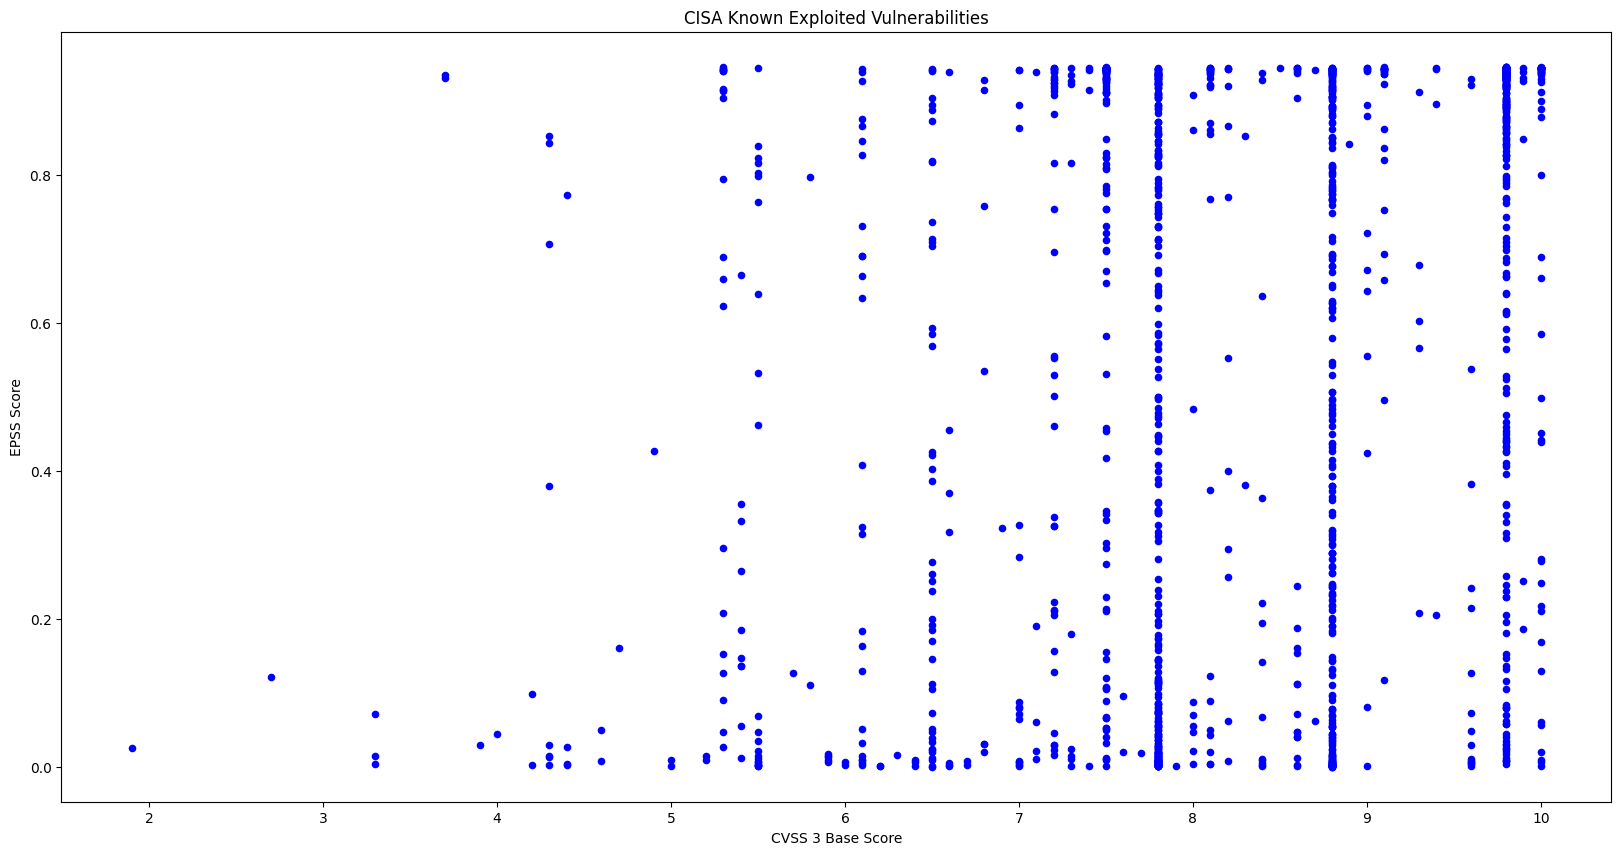

In [7]:
ax = epss_kev_nvd.plot.scatter(x='CVSS3',
                                 y='EPSS',
                                 figsize=(20, 10),
                                 title='CISA Known Exploited Vulnerabilities',
                                 color='blue')
ax.set_xlabel("CVSS 3 Base Score")
ax.set_ylabel("EPSS Score")
ax.get_figure().savefig('epss_kev_nvd.png')

## Export to CVS

In [8]:
epss_kev_nvd.to_csv("epss_kev_nvd.csv", index=False)
epss_kev_nvd.head(10)

,CVE,CVSS3,EPSS,EPSS Percentile,Description,Vendor,Product
0,CVE-2025-11953,9.8,0.06952,0.91221,React Native Community CLI contains an OS comm...,React Native Community,CLI
1,CVE-2021-39935,6.8,0.53463,0.97908,GitLab Community and Enterprise Editions conta...,GitLab,Community and Enterprise Editions
2,CVE-2025-64328,7.2,0.20561,0.95420,Sangoma FreePBX Endpoint Manager contains an O...,Sangoma,FreePBX
3,CVE-2019-19006,9.8,0.31613,0.96666,Sangoma FreePBX contains an improper authentic...,Sangoma,FreePBX
4,CVE-2025-40551,9.8,0.22938,0.95752,SolarWinds Web Help Desk contains a deserializ...,SolarWinds,Web Help Desk
5,CVE-2018-14634,NaN,0.11529,0.93450,Linux Kernel contains an integer overflow vuln...,Linux,Kernal
6,CVE-2025-52691,10.0,0.79965,0.99071,SmarterTools SmarterMail contains an unrestric...,SmarterTools,SmarterMail
7,CVE-2024-37079,9.8,0.79309,0.99038,Broadcom VMware vCenter Server contains an out...,Broadcom,VMware vCenter Server
8,CVE-2025-68645,8.8,0.28121,0.96354,Synacor Zimbra Collaboration Suite (ZCS) conta...,Synacor,Zimbra Collaboration Suite (ZCS)
9,CVE-2025-34026,7.5,0.45819,0.97526,Versa Concerto SD-WAN orchestration platform c...,Versa,Concerto
